In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.tools as tls
import seaborn as sns
%matplotlib nbagg

In [3]:
#Create connection to SQLite database
con= sqlite3.connect('sf_salaries.sqlite')

#Use pandas to query database
police= pd.read_sql_query('''SELECT * FROM Salaries WHERE JobTitle LIKE '%POLICE%' ''',con)

In [4]:
police.head(1)#A little messy, we'll get rid of unneplcessary columns

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966,245131.88,137811.38,,538909.28,538909.28,2011,,San Francisco,


In [5]:
policeClean= police.drop(['Id','EmployeeName','JobTitle','Notes','Agency','Status'], axis= 1)
#Year 2011 has more complete info than other years, let's work with that
police2011= policeClean[policeClean['Year'] == 2011]

In [6]:
police2011.head()#Let's take a quick look at the data

,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year
0,155966,245131.88,137811.38,,538909.28,538909.28,2011
1,212739,106088.18,16452.60,,335279.91,335279.91,2011
2,99722,87082.62,110804.30,,297608.92,297608.92,2011
3,198778,73478.20,13957.65,,286213.86,286213.86,2011
4,256470,0.00,11522.18,,267992.59,267992.59,2011


In [7]:
#Now let's split this into a training and test dataset to 
from sklearn.cross_validation import train_test_split

train2011, test2011 = train_test_split(police2011, test_size = 0.2)

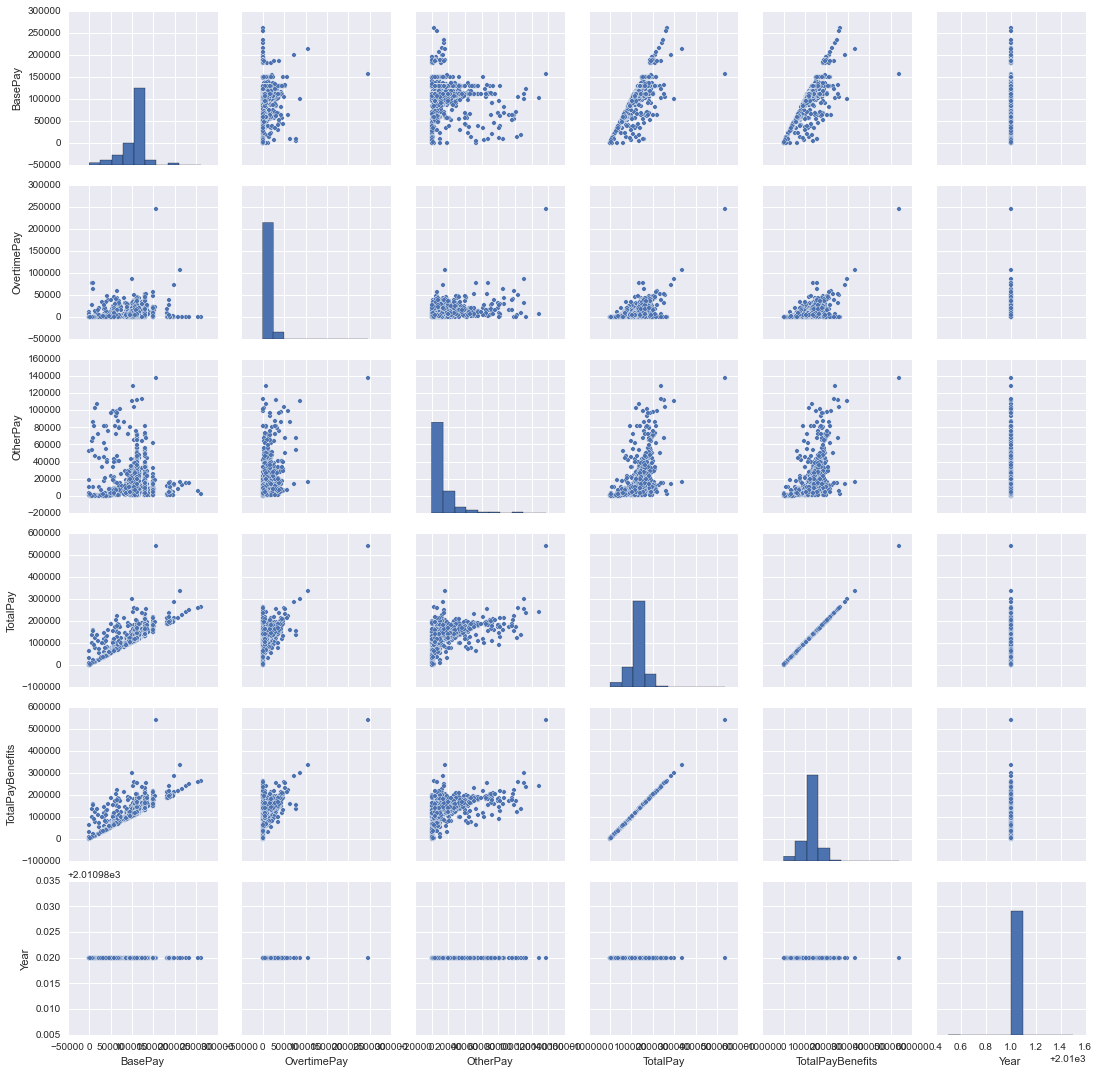

In [29]:
#Now let's see if we can identify any trends by plotting the series against one another
%matplotlib inline
sns.pairplot(train2011)

<IPython.core.display.Javascript object>


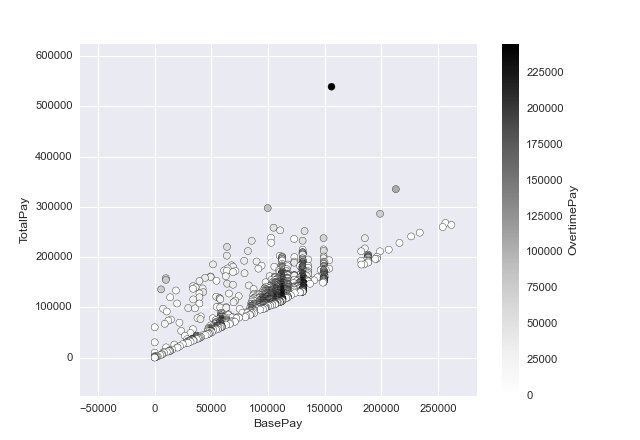

In [11]:
#Now we'll plot BasePay against TotalPay (no benefits in either), with OvertimePay on a third, colored axis
police2011.plot(kind= 'scatter', x= 'BasePay',y= 'TotalPay', c= 'OvertimePay',s= 40)